In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
train_data = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-training-data.csv", sep=";")
building = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-metadata.csv", sep=";")
weather = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-weather.csv", sep=";")
holidays = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-holidays.csv", sep=";")

In [28]:
print(train_data.columns)
print(building.columns)
print(weather.columns)
print(holidays.columns)

Index(['meter_id', 'Timestamp', 'Values'], dtype='object')
Index(['site_id', 'meter_id', 'meter_description', 'units', 'surface',
       'activity'],
      dtype='object')
Index(['Timestamp', 'Temperature', 'Distance', 'site_id'], dtype='object')
Index(['Date', 'Holiday', 'site_id'], dtype='object')


In [29]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data['Weekday'] = train_data['Timestamp'].dt.weekday
train_data['Hour'] = train_data['Timestamp'].dt.hour
train_data['Minute'] = train_data['Timestamp'].dt.minute
train_data['Month'] = train_data['Timestamp'].dt.month
train_data.sort_values(by="Timestamp", ascending=True, inplace=True)

In [5]:
weather["Timestamp"] = pd.to_datetime(weather["Timestamp"])
weather.sort_values(by="Timestamp", ascending=True, inplace=True)

In [33]:
# Removed null values and filtered site 38 as data weather and building data available for site 38
train = train_data[train_data["meter_id"].str.startswith("38") & ~train_data["Values"].isna()]
train

,meter_id,Timestamp,Values,Weekday,Hour,Minute,Month
2806897,38_10106,2010-09-01 03:30:00+05:30,7.062570e+05,2,3,30,9
232773,38_10109,2010-09-01 03:30:00+05:30,1.089994e+06,2,3,30,9
2083012,38_10108,2010-09-01 03:30:00+05:30,2.960981e+06,2,3,30,9
1340099,38_10112,2010-09-01 03:30:00+05:30,1.416098e+04,2,3,30,9
1653058,38_10107,2010-09-01 03:30:00+05:30,-8.538100e+04,2,3,30,9
...,...,...,...,...,...,...,...
2082112,38_10106,2017-12-05 14:45:00+05:30,1.574033e+06,1,14,45,12
599124,38_10111,2017-12-05 14:45:00+05:30,2.358010e+06,1,14,45,12
1939242,38_10110,2017-12-05 14:45:00+05:30,1.782837e+07,1,14,45,12
1998286,38_10107,2017-12-05 14:45:00+05:30,1.857750e+05,1,14,45,12


In [34]:
# Confirms that all meter_ids are unique in building data
print(building["meter_id"].nunique() == building[~building["meter_id"].isna()].shape[0])

# Filtering for site 38 and only those meter_ids which are present in the train_data
final_building = building[(building["site_id"] == "038") & (building["meter_id"].isin(train["meter_id"].unique()))]
final_building

True


,site_id,meter_id,meter_description,units,surface,activity
27,038,38_10110,other,kWh,NaN,laboratory
87,038,38_10112,compressed air,kWh,NaN,laboratory
118,038,38_10107,laboratory,kWh,NaN,laboratory
119,038,38_10111,cold group,kWh,NaN,laboratory
121,038,38_10106,guardhouse,kWh,NaN,laboratory
159,038,38_10109,lighting,kWh,NaN,laboratory
161,038,38_0,outside temperature,degree celsius,NaN,general
166,038,38_10108,laboratory,kWh,NaN,laboratory
172,038,38_1,total workers,count,NaN,general


In [8]:
# removing null values in site id
weather = weather[~weather["site_id"].isna()]
print(weather.shape)
print(weather["Timestamp"].nunique())
weather_unique = weather.groupby(["Timestamp"]).first()
print(weather_unique.shape)
weather_unique.reset_index(inplace=True)
print(weather_unique["Timestamp"].nunique())
weather_unique["Timestamp"] = pd.to_datetime(weather_unique["Timestamp"])
weather_unique

(51164, 4)
51158
(51158, 3)
51158


,Timestamp,Temperature,Distance,site_id
0,2012-01-01 06:30:00+05:30,3.9,11.902932,38.0
1,2012-01-01 07:30:00+05:30,4.1,11.902932,38.0
2,2012-01-01 08:30:00+05:30,4.2,11.902932,38.0
3,2012-01-01 09:30:00+05:30,4.1,11.902932,38.0
4,2012-01-01 10:30:00+05:30,4.3,11.902932,38.0
...,...,...,...,...
51153,2017-12-17 23:30:00+05:30,2.0,11.902932,38.0
51154,2017-12-18 00:30:00+05:30,0.5,11.902932,38.0
51155,2017-12-18 01:30:00+05:30,0.1,11.902932,38.0
51156,2017-12-18 02:30:00+05:30,-0.2,11.902932,38.0


### Merging meter_description and activity 

In [9]:
train = train.merge(final_building[["meter_id", "meter_description", "activity"]], how="left", on="meter_id")
train

,meter_id,Timestamp,Values,Weekday,Hour,Minute,Month,meter_description,activity
0,38_10106,2010-09-01 03:30:00+05:30,7.062570e+05,2,3,30,9,guardhouse,laboratory
1,38_10109,2010-09-01 03:30:00+05:30,1.089994e+06,2,3,30,9,lighting,laboratory
2,38_10108,2010-09-01 03:30:00+05:30,2.960981e+06,2,3,30,9,laboratory,laboratory
3,38_10112,2010-09-01 03:30:00+05:30,1.416098e+04,2,3,30,9,compressed air,laboratory
4,38_10107,2010-09-01 03:30:00+05:30,-8.538100e+04,2,3,30,9,laboratory,laboratory
...,...,...,...,...,...,...,...,...,...
1768545,38_10106,2017-12-05 14:45:00+05:30,1.574033e+06,1,14,45,12,guardhouse,laboratory
1768546,38_10111,2017-12-05 14:45:00+05:30,2.358010e+06,1,14,45,12,cold group,laboratory
1768547,38_10110,2017-12-05 14:45:00+05:30,1.782837e+07,1,14,45,12,other,laboratory
1768548,38_10107,2017-12-05 14:45:00+05:30,1.857750e+05,1,14,45,12,laboratory,laboratory


### Merging temperature and distance at which temperature is recorded

In [10]:
train_final = train.merge(weather_unique[["Timestamp", "Temperature", "Distance"]], how="left", on="Timestamp")
train_final

,meter_id,Timestamp,Values,Weekday,Hour,Minute,Month,meter_description,activity,Temperature,Distance
0,38_10106,2010-09-01 03:30:00+05:30,7.062570e+05,2,3,30,9,guardhouse,laboratory,NaN,NaN
1,38_10109,2010-09-01 03:30:00+05:30,1.089994e+06,2,3,30,9,lighting,laboratory,NaN,NaN
2,38_10108,2010-09-01 03:30:00+05:30,2.960981e+06,2,3,30,9,laboratory,laboratory,NaN,NaN
3,38_10112,2010-09-01 03:30:00+05:30,1.416098e+04,2,3,30,9,compressed air,laboratory,NaN,NaN
4,38_10107,2010-09-01 03:30:00+05:30,-8.538100e+04,2,3,30,9,laboratory,laboratory,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1768545,38_10106,2017-12-05 14:45:00+05:30,1.574033e+06,1,14,45,12,guardhouse,laboratory,NaN,NaN
1768546,38_10111,2017-12-05 14:45:00+05:30,2.358010e+06,1,14,45,12,cold group,laboratory,NaN,NaN
1768547,38_10110,2017-12-05 14:45:00+05:30,1.782837e+07,1,14,45,12,other,laboratory,NaN,NaN
1768548,38_10107,2017-12-05 14:45:00+05:30,1.857750e+05,1,14,45,12,laboratory,laboratory,NaN,NaN


In [11]:
train_final["meter_id"].value_counts()

38_10108    249674
38_10109    249672
38_10110    249561
38_10106    248984
38_10112    247263
38_10111    246761
38_10107    223517
38_1         42240
38_0         10878
Name: meter_id, dtype: int64

In [17]:
# Selecting 38_10108 and proceeding to detect anomalies in that meter
train_selected = train_final[train_final["meter_id"] == "38_10110"]

### Plotting the time series

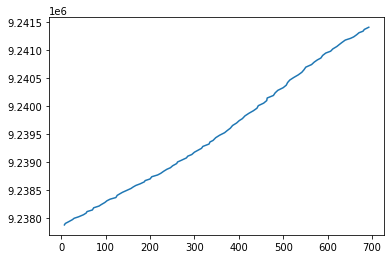

In [18]:
plt.plot(train_selected.loc[:700,'Values'])
plt.show()